### **I. Installation**

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns

### For tracking carbon emissions
%pip install codecarbon
from codecarbon import EmissionsTracker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.9/494.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 700.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 13.7 MB/s eta 0:00:00


In [ ]:
### Access the google drive folder via google colab
drive.mount('/content/drive')

Mounted at /content/drive


### **II. Loading the U.S. Residential Energy Consumption Survey (2020)**

In [ ]:
### Define a function for reading in csv files

file_path = '/content/drive/My Drive/[ML Project] Energy/1_Data'

def load_csv(filename):

  # Construct a full file path
  full_path = f'{file_path}/{filename}.csv'

  # Specify the columns of interest
  # key = original column name
  # value = new column name
  subset_cols = {

      ## 1. Geographic characteristics:
      # higher HDD = *colder* the outdoor temperature
      # -> higher energy demand for space *heating*
      'HDD65': 'HEATING_DEGREE_DAYS',
      # higher CDD = *hotter* the outdoor temperature
      # -> higher energy demand for space *cooling*
      'CDD65': 'COOLING_DEGREE_DAYS',

      ## 2. Energy bills:
      'TOTALBTU': 'TOTAL_USAGE', # Total energy usage, 2020 (thousand Btu)
      'TOTSQFT_EN': 'TOTAL_AREA', # Total energy consuming area of the home (sq footage)

      ## 3. Home characteristics:
      'DRAFTY': 'DRAFTY',

      ## 4. Household characteristics:
      'MONEYPY': 'INCOME',
      'SCALEB': 'FREQ_FORGO_NECESSITIES',
      'SCALEG': 'FREQ_UNHEALTHY_TEMP',
      'SCALEE': 'FREQ_DISCONNECTION',
      'EDUCATION': 'EDUCATION',
      'SDESCENT': 'HISPANIC',
      'HOUSEHOLDER_RACE': 'RACE',
      'NHSLDMEM': 'HOUSEHOLD_SIZE'}

  # Store column names (original & modified) as a list
  old_colnames = list(subset_cols.keys())
  new_colnames = list(subset_cols.values())

  # Load the data
  data = pd.read_csv(full_path, usecols = old_colnames)

  # Rename & rearrange the columns
  data = data.rename(columns = subset_cols)
  data = data[new_colnames]

  display(data.head(3))

  return data

In [ ]:
recs = load_csv('RECS_2020_Version_7')

,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_USAGE,TOTAL_AREA,DRAFTY,INCOME,FREQ_FORGO_NECESSITIES,FREQ_UNHEALTHY_TEMP,FREQ_DISCONNECTION,EDUCATION,HISPANIC,RACE,HOUSEHOLD_SIZE
0,3844,1679,144647.71,2100,3,13,0,0,0,5,0,1,2
1,3766,1458,28034.61,590,3,6,0,0,0,3,0,1,1
2,3819,1696,30749.71,900,4,11,0,0,0,4,0,1,1


### **III. Feature engineering**

In [ ]:
### Instantiate carbon tracker (for transparency & reporting purposes)

tracker = EmissionsTracker()
tracker.start()

[codecarbon WARNING @ 03:39:03] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 03:39:03] [setup] RAM Tracking...
[codecarbon INFO @ 03:39:03] [setup] GPU Tracking...
[codecarbon INFO @ 03:39:03] No GPU found.
[codecarbon INFO @ 03:39:03] [setup] CPU Tracking...
[codecarbon WARNING @ 03:39:03] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 03:39:05] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 03:39:05] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 03:39:05] >>> Tracker's metadata:
[codecarbon INFO @ 03:39:05]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 03:39:05]   Python version: 3.10.12
[codecarbon INFO @ 03:39:05]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 03:39:05]   Available RAM : 12.675 GB
[codecarbon INFO @ 03:39:05]   CPU count: 2
[codecarbon INFO @ 03:39:05]   CP

In [ ]:
### Define functions for mapping new values

def convert_to_binary(column, values_to_be_coded_as_1, label_as_1, label_as_0):
  recs[column] = np.where(recs[column].isin(values_to_be_coded_as_1), label_as_1, label_as_0)

def recode_based_on_condition(column, conditions, new_values, default):
    recs[column] = np.select(conditions, new_values,
                             # if none of conditions are met, code as:
                             default = default)

**A. Create new variables**

In [ ]:
### Create an indicator for energy insecurity

# Define conditions for an energy *secure* household
energy_security = [(recs['FREQ_FORGO_NECESSITIES'] == 0) & (recs['FREQ_UNHEALTHY_TEMP'] == 0) & (recs['FREQ_DISCONNECTION'] == 0)]

# If a household has experienced any of the 3 difficulties, code as Energy *insecure*
recode_based_on_condition('ENERGY_INSECURE', energy_security, ['Non energy-insecure'], 'Energy-insecure')

In [ ]:
### Combine racial & ethnic categories, for simplicity
### Instead of distinguishing between 4 categories:
### Hispanic/Latino, White (Non-Hispanic), Black (Non-Hispanic), Asian (Non-Hispanic), Other
### I chose to combine Hispanic/Latino + Black + Other ethnic minorities, as they - on average -
# tended to live in homes of similar sizes and with similar levels of draftiness,
# had similar education levels, and
# had relatively similar energy usage (k btu)

# Define the combination of racial & ethnic groups (= conditions for assignment)
race_x_ethnicity = [
    # Non-Hispanic White
    (recs['HISPANIC'] == 0) & (recs['RACE'] == 1),
    # Non-Hispanic Asian
    (recs['HISPANIC'] == 0) & (recs['RACE'] == 4)]

# Define the newly assigned values for each condition
recoded_category = [
    'White (Non-Hispanic)',
    'Asian (Non-Hispanic)']

# Create a new variable that simultaneously takes into account the race & ethnicity of householders
recode_based_on_condition('RACE_ETHNIC', race_x_ethnicity, recoded_category, 'Hispanic/Latino/Black/Other ethnic minorities')

**B. Convert to binary variables**

In [ ]:
### Drafty home: 1 (All the time, Most of the time, Some of the time) / 0 (Never)
convert_to_binary('DRAFTY', [1, 2, 3], 'Drafty', 'Tight-sealed')

### Educational attainment: 1 (BA or higher) / 0 (No BA)
convert_to_binary('EDUCATION', [4, 5], "Bachelor's degree or higher", "No Bachelor's degree")

**C. Collapse factor levels**

In [ ]:
### Income levels

# Define income categories (= conditions for assignment)
income = [
    recs['INCOME'].isin(range(1, 12)), # Low income (2019)
    recs['INCOME'].isin(range(12, 15))] # Middle income (2019)

# Define the newly assigned values for each income bracket
recoded_income = [
    'Low',
    'Middle']

# Reduce the number of income categories
recode_based_on_condition('INCOME', income, recoded_income, 'High')

**D. Remove outliers**

***a) Filter the dataset***

In [ ]:
### Remove outliers from variables with highly skewed distributions

def remove_outliers(df, columns):
  '''
  Remove outliers of specified list of columns, using the IQR method
  A row is removed if it is an outlier in *any* of the columns
  '''
  # Create a mask that indicates whether to keep a given row (to be updated)
  outlier_mask = pd.Series([False] * len(df))

  for column in columns:

    # Calculate the IQR for a given column column
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Update the mask. True = outlier for at least 1 of the specified columns.
    is_outlier = (df[column] < lower_bound) | (df[column] > upper_bound)
    outlier_mask = outlier_mask | is_outlier

  # Filter the dataframe
  df_wo_outliers = df[~outlier_mask]
  return df_wo_outliers

In [ ]:
### Remove outliers from total energy usage & total energy consuming area of the home

columns_to_clean = ['TOTAL_USAGE', 'TOTAL_AREA']
RECS = remove_outliers(recs, columns_to_clean)

***b) Examine the distribution of the data***

In [ ]:
### For simplicity, convert digits into units of 1000

def format_numbers(value, formatted_number):
    return f'{value / 1000:.0f}'

### Visualize the improvement in skewness

def compare_distributions(df, df_wo_outlier, columns, plot_titles, axis_titles):
    '''
    Compare the distribution of the data, with & without outliers, for multiple columns
    '''
    print(f'Number of rows deleted: {df.shape[0] - df_wo_outlier.shape[0]}\n')

    sns.set_theme(style = 'ticks')

    for i, column in enumerate(columns):
        plt.figure(figsize = (8, 4))

        ''' A box plot for before vs. after '''

        # A box plot before removing the outliers
        plt.subplot(2, 2, 1)
        sns.boxplot(x = df[column], orient = 'h')
        plt.title(f'{plot_titles[i]}: $\\it{{With}}$ outliers', loc = 'left', weight = 'bold', fontsize = 10)
        plt.xlabel('')
        plt.ylabel('')
        plt.tick_params(axis = 'both', which = 'major', labelsize = 8)
        plt.gca().xaxis.set_major_formatter(FuncFormatter(format_numbers))

        # A box plot after removing the outliers
        plt.subplot(2, 2, 2)
        sns.boxplot(x = df_wo_outlier[column], orient = 'h', color = 'green')
        plt.title(f'{plot_titles[i]}: $\\it{{Without}}$ outliers', loc = 'left', weight = 'bold', fontsize = 10)
        plt.xlabel('')
        plt.ylabel('')
        plt.tick_params(axis = 'both', which = 'major', labelsize = 8)
        plt.gca().xaxis.set_major_formatter(FuncFormatter(format_numbers))

        ''' A histogram for before vs. after '''

        # A histogram before removing the outliers
        plt.subplot(2, 2, 3)
        sns.histplot(df[column], kde = True, color = 'blue', edgecolor = 'black')
        plt.xlabel(axis_titles[i], weight = 'bold', fontsize = 9)
        plt.ylabel('Frequency', fontsize = 10)
        plt.tick_params(axis = 'both', which = 'major', labelsize = 8)
        plt.gca().xaxis.set_major_formatter(FuncFormatter(format_numbers))

        # A histogram after removing the outliers
        plt.subplot(2, 2, 4)
        sns.histplot(df_wo_outlier[column], kde = True, color = 'green', edgecolor = 'black')
        plt.xlabel(axis_titles[i], weight = 'bold', fontsize = 9)
        plt.ylabel('Frequency', fontsize = 10)
        plt.tick_params(axis = 'both', which = 'major', labelsize = 8)
        plt.gca().xaxis.set_major_formatter(FuncFormatter(format_numbers))

        plt.tight_layout()
        plt.show()

Number of rows deleted: 895



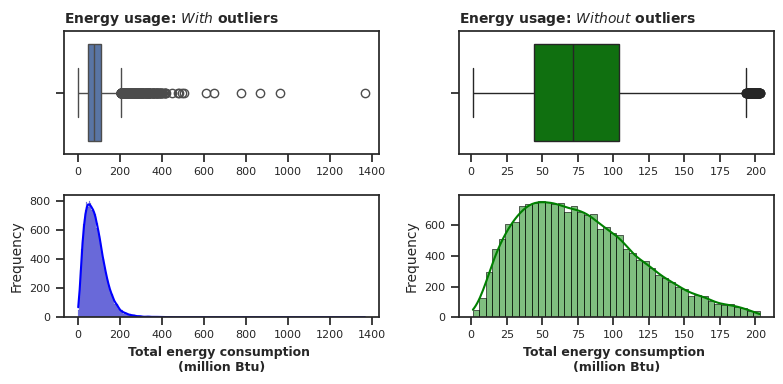

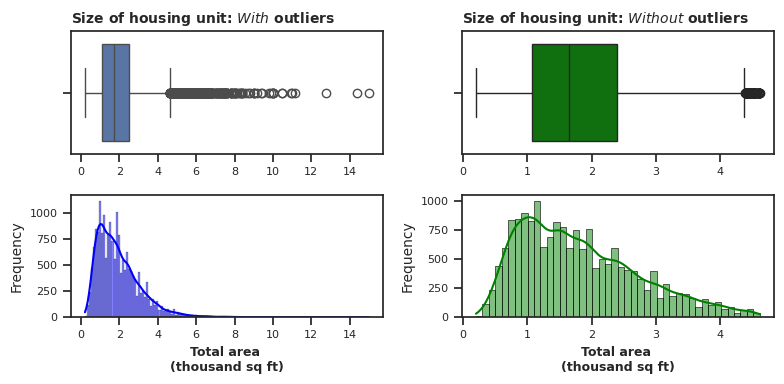

In [ ]:
### Plot the box plot and histograms for 1) total energy consumption & 2) total area

plot_titles = ['Energy usage', 'Size of housing unit']
axis_titles = ['Total energy consumption \n(million Btu)', 'Total area \n(thousand sq ft)']
compare_distributions(recs, RECS, columns_to_clean, plot_titles, axis_titles)

**E. Remove and rearrange the variables**


In [ ]:
def save_and_print_data(df, file_name, columns_to_drop, index_position):

  # Rearrange the columns in the specified order
  for column, index in index_position.items():

    # Remove the columns to be rearranged
    df = df.copy()
    extracted_column = df.pop(column)
    # Place the extracted column in the designated position
    df.insert(index, column, extracted_column)

  # Remove variables that we no longer need for analysis
  df.drop(columns = columns_to_drop, inplace = True)

  # Save the dataframe to .csv
  full_path = f'{file_path}/{file_name}.csv'
  df.to_csv(full_path, index = False)

  print('Dataframe was saved successfully! \n')

  # Examine dimensionality, shape of the dataframe
  print(f'{df.shape[0]} observations \n{df.shape[1]} variables \n')
  print('The first 3 rows:')
  display(df.head(3))

  return df

In [ ]:
### Define variables to remove
unnecessary_variables = [
    'HISPANIC', 'RACE',
    'FREQ_FORGO_NECESSITIES', 'FREQ_UNHEALTHY_TEMP', 'FREQ_DISCONNECTION']

### Define where to insert a given column
# '+ n' increases because the index shifts as we extract & insert variables into the dataframe
index_position = {
    # Position energy-insecurity related variables one after another
    'ENERGY_INSECURE': RECS.columns.get_loc('INCOME') + 1,
    # Insert racial/ethic category after 'EDUCATION'
    'RACE_ETHNIC': RECS.columns.get_loc('EDUCATION') + 2}

### Store the data and print out info
RECS = save_and_print_data(RECS, 'RECS_2020 (CLEANED)', unnecessary_variables, index_position)

Dataframe was saved successfully! 

17601 observations 
10 variables 

The first 3 rows:


,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_USAGE,TOTAL_AREA,DRAFTY,INCOME,ENERGY_INSECURE,EDUCATION,RACE_ETHNIC,HOUSEHOLD_SIZE
0,3844,1679,144647.71,2100,Drafty,Middle,Non energy-insecure,Bachelor's degree or higher,White (Non-Hispanic),2
1,3766,1458,28034.61,590,Drafty,Low,Non energy-insecure,No Bachelor's degree,White (Non-Hispanic),1
2,3819,1696,30749.71,900,Tight-sealed,Low,Non energy-insecure,Bachelor's degree or higher,White (Non-Hispanic),1


### **IV. Track carbon emissions**


In [ ]:
### Display the amount of carbon emissions

emissions: float = tracker.stop()
print(f"Emissions: {emissions} kg")

[codecarbon INFO @ 03:39:14] Energy consumed for RAM : 0.000011 kWh. RAM Power : 4.753040313720703 W
[codecarbon INFO @ 03:39:14] Energy consumed for all CPUs : 0.000100 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:39:14] 0.000111 kWh of electricity used since the beginning.


Emissions: 5.0203838153275524e-05 kg
